<AxesSubplot:xlabel='Date'>

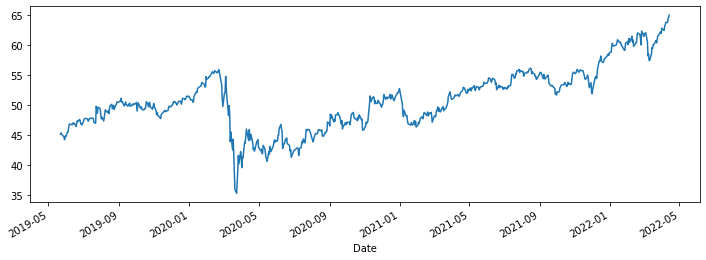

In [1]:
#!pip install yfinance
import yfinance as yf
tickerS = "KO"
tickerData = yf.Ticker(tickerS)
tickerDf = tickerData.history(start = '2019-05-23', end = '2022-04-17', interval="1d", actions=False)
tickerDf.Close.plot(figsize=(12, 4))

In [2]:
def traiding(high_train, low_train, high_test, low_test, close, l):
    all_profit = 0
    profit = 0
    pos = False
    num_steps = len(close)
    deals = []
    comission = 0.04
    for step in range(num_steps):
        buy_price = low_train[step]*l
        sell_price = high_train[step]*l
        if buy_price >= low_test[step]:
            pos = True
            profit -= comission /100 * buy_price
        if pos:
            if sell_price <= high_test[step]:
                p = sell_price-buy_price
                status = 'succes'
                #print("_________________________________________________________")
            else:
                sell_price = close[step]
                p = sell_price*(1-comission/100)-buy_price
                if p<=0:
                    status = 'failed'
                else:
                    status = 'ыбыбыб'
            profit += p
            pos = False
            deals.append({'status' : status, 'buy_price' : buy_price, 'sell_price' : sell_price, 'profit' : p})
    return deals

In [3]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

def regressor(high, prediction_columns):
    x = high[prediction_columns[1:]]#.values
    y = high[prediction_columns[0]]#.values.reshape(-1,1)
    high_x_train, high_x_test, high_train, high_test = train_test_split(x, y, test_size=0.33, random_state = 42, shuffle = False)
    catboost_high = CatBoostRegressor(iterations=500,
                                   learning_rate=0.03,
                                   depth=8,
                                   l2_leaf_reg=7,
                                   loss_function='MAE')
    catboost_high.fit(high_x_train, high_train)
    return catboost_high, high_x_test, high_test

def inversion(a, high_min, lambda_high, high1):
    #inv_high_test_from_minmax_to_diff = inv_minmax(a.reshape(-1,1), high_min)
    #inv_high_test_from_diff_to_boxcox = inv_diff(high1, inv_high_test_from_minmax_to_diff.reshape(-1))
    #inv_high_test = inv_boxcox(inv_high_test_from_diff_to_boxcox.reshape(-1), lambda_high)
    inv_high_test = inv_diff(high1, a.reshape(-1))
    return inv_high_test

def boxcoxMy(data, columnOld, columnNew):
    trans, lambda_ = boxcox(data[columnOld].values)
    data[columnNew] = trans
    return lambda_

def inv_boxcoxMyforLag(data, lambda_, columnOld, columnNew):
    #data[columnNew] = inv_boxcox(data[columnOld].values, lambda_)
    #data[columnNew].plot()
    data[columnOld] = inv_boxcox(data[columnOld].values, lambda_)
    
def inv_box_cox(data, lambda_):
    return inv_boxcox(data, lambda_)
    
def diff(data, columnOld, columnNew):
    data[columnNew] = data[columnOld].diff()
    #data[columnNew].plot()
    
def inv_diff(high1, high_test):
    return high1[len(high1) - len(high_test)-1:-1]+high_test

def anotherDiff(data, columnOld, columnNew):
    data[columnNew] = data[columnOld].pct_change()
    #data[columnNew].plot()

def minmax(data, columnOld, columnNew):
    scaler = MinMaxScaler()
    data[columnNew] = scaler.fit_transform(data[columnOld].values.reshape(-1,1))
    #data[columnNew].plot()
    return scaler.fit(data[columnOld].values.reshape(-1,1))

def inv_minmax(data, obj):
    #scaler = MinMaxScaler()
    #scaler = scaler.fit(data[columnOld].values.reshape(-1,1))
    #data[columnNew] = scaler.inverse_transform(data[columnOld].values.reshape(-1,1))
    #data[columnOld] = scaler.inverse_transform(data[columnOld].values.reshape(-1,1))
    return obj.inverse_transform(data).reshape(-1,1)
    
def lag_fich(data, prediction_columns):
    for i in range(1, prediction_window+1):
        col_name = f'shift_{i}'
        prediction_columns.append(col_name)
        data[col_name] = data[prediction_columns[0]].shift(i)
    #data.plot()
    return data[prediction_columns].dropna()

def metrics(inv_high_x, inv_high_test):
    from sklearn.metrics import mean_squared_error
    print('mean_squared_error', mean_squared_error(inv_high_x,inv_high_test))

    from sklearn.metrics import mean_absolute_error
    print('mean_absolute_error',mean_absolute_error(inv_high_test, inv_high_x))

    from sklearn.metrics import mean_absolute_percentage_error
    print('mean_absolute_percentage_error',mean_absolute_percentage_error(inv_high_test, inv_high_x))
    
    from sklearn.metrics import r2_score
    print('r2_score (R^2)', r2_score(inv_high_test,inv_high_x))

In [4]:
lag = 20

#tickerDf = tickerDf.reset_index()

low = tickerDf.copy()
high = tickerDf.copy()
close = tickerDf.copy()

#lambda_high = boxcoxMy(high, 'High', 'boxcox')
#lambda_low = boxcoxMy(low, 'Low', 'boxcox')
#lambda_close =boxcoxMy(close, 'Close', 'boxcox')
high1 = high['High'].values[lag:].copy()
low1 = low['Low'].values[lag:].copy()

diff(high, 'High', 'diff')
diff(low, 'Low', 'diff')
#diff(close, 'boxcox', 'diff')
#anotherDiff(close, 'Close', 'anotherDiff')
#high_min = minmax(high, 'diff', 'minmax_scaler')
#low_min = minmax(low, 'diff', 'minmax_scaler')
#minmax(close, 'boxcox', 'minmax_scaler')

In [5]:
prediction_window = lag
prediction_columns = ['Close']
close = lag_fich(close, prediction_columns)

prediction_window = lag
prediction_columns = ['diff']
high = lag_fich(high, prediction_columns)
prediction_window = lag
prediction_columns = ['diff']
low = lag_fich(low, prediction_columns)

In [6]:
regressor_high, high_x_test, high_test = regressor(high, prediction_columns)

0:	learn: 0.4320060	total: 157ms	remaining: 1m 18s
1:	learn: 0.4293112	total: 178ms	remaining: 44.3s
2:	learn: 0.4259784	total: 199ms	remaining: 32.9s
3:	learn: 0.4220654	total: 224ms	remaining: 27.8s
4:	learn: 0.4188962	total: 244ms	remaining: 24.1s
5:	learn: 0.4159255	total: 262ms	remaining: 21.6s
6:	learn: 0.4136205	total: 273ms	remaining: 19.2s
7:	learn: 0.4088987	total: 283ms	remaining: 17.4s
8:	learn: 0.4042111	total: 294ms	remaining: 16.1s
9:	learn: 0.4007611	total: 310ms	remaining: 15.2s
10:	learn: 0.3959707	total: 322ms	remaining: 14.3s
11:	learn: 0.3917302	total: 332ms	remaining: 13.5s
12:	learn: 0.3887996	total: 347ms	remaining: 13s
13:	learn: 0.3861397	total: 362ms	remaining: 12.6s
14:	learn: 0.3825566	total: 374ms	remaining: 12.1s
15:	learn: 0.3794154	total: 390ms	remaining: 11.8s
16:	learn: 0.3762538	total: 404ms	remaining: 11.5s
17:	learn: 0.3731549	total: 414ms	remaining: 11.1s
18:	learn: 0.3692390	total: 425ms	remaining: 10.8s
19:	learn: 0.3664649	total: 438ms	remainin

166:	learn: 0.1323404	total: 2.12s	remaining: 4.22s
167:	learn: 0.1316875	total: 2.13s	remaining: 4.21s
168:	learn: 0.1308557	total: 2.14s	remaining: 4.19s
169:	learn: 0.1296872	total: 2.15s	remaining: 4.17s
170:	learn: 0.1290081	total: 2.16s	remaining: 4.16s
171:	learn: 0.1280978	total: 2.17s	remaining: 4.14s
172:	learn: 0.1276590	total: 2.18s	remaining: 4.12s
173:	learn: 0.1266578	total: 2.19s	remaining: 4.11s
174:	learn: 0.1261600	total: 2.2s	remaining: 4.09s
175:	learn: 0.1258196	total: 2.22s	remaining: 4.08s
176:	learn: 0.1253759	total: 2.23s	remaining: 4.07s
177:	learn: 0.1249233	total: 2.24s	remaining: 4.05s
178:	learn: 0.1244086	total: 2.25s	remaining: 4.04s
179:	learn: 0.1238991	total: 2.26s	remaining: 4.02s
180:	learn: 0.1231583	total: 2.27s	remaining: 4s
181:	learn: 0.1227031	total: 2.28s	remaining: 3.99s
182:	learn: 0.1219921	total: 2.3s	remaining: 3.98s
183:	learn: 0.1213344	total: 2.31s	remaining: 3.97s
184:	learn: 0.1208009	total: 2.33s	remaining: 3.96s
185:	learn: 0.120

325:	learn: 0.0664030	total: 3.85s	remaining: 2.06s
326:	learn: 0.0661754	total: 3.86s	remaining: 2.04s
327:	learn: 0.0659632	total: 3.88s	remaining: 2.03s
328:	learn: 0.0657920	total: 3.88s	remaining: 2.02s
329:	learn: 0.0654381	total: 3.9s	remaining: 2.01s
330:	learn: 0.0650738	total: 3.91s	remaining: 2s
331:	learn: 0.0648280	total: 3.92s	remaining: 1.99s
332:	learn: 0.0646703	total: 3.94s	remaining: 1.98s
333:	learn: 0.0643717	total: 3.98s	remaining: 1.98s
334:	learn: 0.0641661	total: 4.01s	remaining: 1.98s
335:	learn: 0.0639444	total: 4.03s	remaining: 1.97s
336:	learn: 0.0637019	total: 4.04s	remaining: 1.96s
337:	learn: 0.0636275	total: 4.06s	remaining: 1.95s
338:	learn: 0.0634621	total: 4.07s	remaining: 1.93s
339:	learn: 0.0632708	total: 4.08s	remaining: 1.92s
340:	learn: 0.0631437	total: 4.09s	remaining: 1.91s
341:	learn: 0.0630752	total: 4.11s	remaining: 1.9s
342:	learn: 0.0629005	total: 4.12s	remaining: 1.89s
343:	learn: 0.0628111	total: 4.13s	remaining: 1.87s
344:	learn: 0.062

488:	learn: 0.0445512	total: 5.81s	remaining: 131ms
489:	learn: 0.0445111	total: 5.83s	remaining: 119ms
490:	learn: 0.0444694	total: 5.84s	remaining: 107ms
491:	learn: 0.0442429	total: 5.86s	remaining: 95.2ms
492:	learn: 0.0441690	total: 5.87s	remaining: 83.3ms
493:	learn: 0.0441013	total: 5.88s	remaining: 71.4ms
494:	learn: 0.0440265	total: 5.89s	remaining: 59.5ms
495:	learn: 0.0439775	total: 5.91s	remaining: 47.6ms
496:	learn: 0.0439258	total: 5.92s	remaining: 35.7ms
497:	learn: 0.0438867	total: 5.93s	remaining: 23.8ms
498:	learn: 0.0437365	total: 5.94s	remaining: 11.9ms
499:	learn: 0.0436647	total: 5.95s	remaining: 0us


<AxesSubplot:>

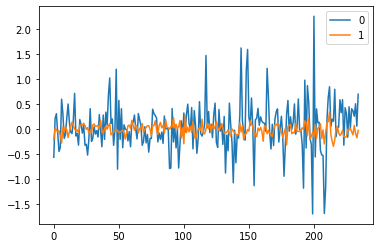

In [7]:
import pandas as pd
df = pd.DataFrame([high_test.values, regressor_high.predict(high_x_test)]).T
df.plot()

In [8]:
#inv_high_test = inversion(high_test.values, high_min, lambda_high, high1)
#inv_high_x = inversion(regressor_high.predict(high_x_test), high_min, lambda_high, high1)

inv_high_test = inversion(high_test.values, high1, high1, high1)
inv_high_x = inversion(regressor_high.predict(high_x_test), high1, high1, high1)

<AxesSubplot:xlabel='Date', ylabel='Price $'>

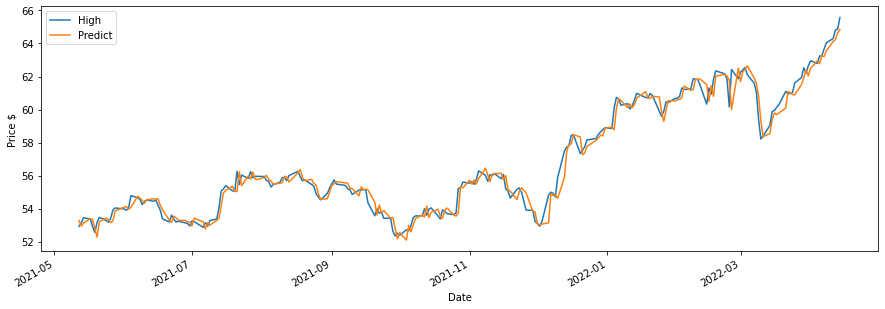

In [9]:
df = pd.DataFrame([tickerDf['High'][-len(inv_high_x):]]).T
df['Predict'] = inv_high_x
df[:].plot(ylabel='Price $',figsize=(15,5))

<AxesSubplot:xlabel='Date', ylabel='Price $'>

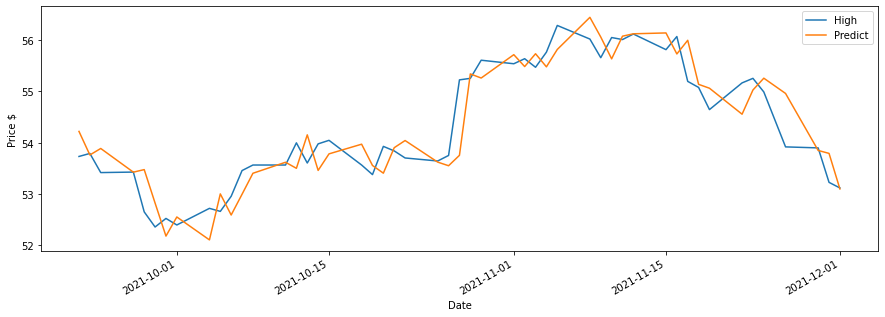

In [10]:
df = pd.DataFrame([tickerDf['High'][-len(inv_high_x):]]).T
df['Predict'] = inv_high_x
df[-len(inv_high_x)//2-25:-len(inv_high_x)//2+25].plot(ylabel='Price $',figsize=(15,5))

In [11]:
metrics(inv_high_x, inv_high_test)

mean_squared_error 0.2473231800386108
mean_absolute_error 0.35872907320720054
mean_absolute_percentage_error 0.006283169506284271
r2_score (R^2) 0.9780638405754396


In [12]:
regressor_low, low_x_test, low_test = regressor(low, prediction_columns)

0:	learn: 0.4671850	total: 17.5ms	remaining: 8.74s
1:	learn: 0.4640100	total: 28.5ms	remaining: 7.09s
2:	learn: 0.4587488	total: 38.4ms	remaining: 6.36s
3:	learn: 0.4540487	total: 48.3ms	remaining: 5.99s
4:	learn: 0.4487125	total: 58.2ms	remaining: 5.76s
5:	learn: 0.4454379	total: 67.9ms	remaining: 5.59s
6:	learn: 0.4414282	total: 77.6ms	remaining: 5.47s
7:	learn: 0.4382745	total: 87.5ms	remaining: 5.38s
8:	learn: 0.4327592	total: 97.4ms	remaining: 5.31s
9:	learn: 0.4295438	total: 107ms	remaining: 5.24s
10:	learn: 0.4254567	total: 119ms	remaining: 5.3s
11:	learn: 0.4208260	total: 129ms	remaining: 5.26s
12:	learn: 0.4176668	total: 140ms	remaining: 5.23s
13:	learn: 0.4139239	total: 149ms	remaining: 5.17s
14:	learn: 0.4108669	total: 159ms	remaining: 5.13s
15:	learn: 0.4082133	total: 168ms	remaining: 5.08s
16:	learn: 0.4037101	total: 178ms	remaining: 5.05s
17:	learn: 0.4005198	total: 193ms	remaining: 5.18s
18:	learn: 0.3976690	total: 206ms	remaining: 5.21s
19:	learn: 0.3937273	total: 217ms

164:	learn: 0.1361103	total: 1.93s	remaining: 3.91s
165:	learn: 0.1352606	total: 1.94s	remaining: 3.9s
166:	learn: 0.1345727	total: 1.95s	remaining: 3.88s
167:	learn: 0.1336680	total: 1.96s	remaining: 3.86s
168:	learn: 0.1331685	total: 1.97s	remaining: 3.85s
169:	learn: 0.1324168	total: 1.97s	remaining: 3.83s
170:	learn: 0.1309848	total: 1.98s	remaining: 3.82s
171:	learn: 0.1299934	total: 1.99s	remaining: 3.8s
172:	learn: 0.1287510	total: 2s	remaining: 3.79s
173:	learn: 0.1278393	total: 2.01s	remaining: 3.77s
174:	learn: 0.1269805	total: 2.02s	remaining: 3.76s
175:	learn: 0.1265728	total: 2.03s	remaining: 3.75s
176:	learn: 0.1260624	total: 2.05s	remaining: 3.73s
177:	learn: 0.1248876	total: 2.06s	remaining: 3.73s
178:	learn: 0.1242207	total: 2.08s	remaining: 3.73s
179:	learn: 0.1237712	total: 2.1s	remaining: 3.73s
180:	learn: 0.1229273	total: 2.11s	remaining: 3.73s
181:	learn: 0.1222369	total: 2.13s	remaining: 3.72s
182:	learn: 0.1215675	total: 2.14s	remaining: 3.71s
183:	learn: 0.1203

327:	learn: 0.0602831	total: 3.83s	remaining: 2.01s
328:	learn: 0.0601001	total: 3.84s	remaining: 2s
329:	learn: 0.0597061	total: 3.85s	remaining: 1.98s
330:	learn: 0.0593981	total: 3.86s	remaining: 1.97s
331:	learn: 0.0592858	total: 3.87s	remaining: 1.96s
332:	learn: 0.0591562	total: 3.88s	remaining: 1.94s
333:	learn: 0.0590427	total: 3.89s	remaining: 1.93s
334:	learn: 0.0587587	total: 3.9s	remaining: 1.92s
335:	learn: 0.0587050	total: 3.91s	remaining: 1.91s
336:	learn: 0.0584656	total: 3.92s	remaining: 1.9s
337:	learn: 0.0582077	total: 3.93s	remaining: 1.88s
338:	learn: 0.0581635	total: 3.94s	remaining: 1.87s
339:	learn: 0.0579701	total: 3.95s	remaining: 1.86s
340:	learn: 0.0578996	total: 3.97s	remaining: 1.85s
341:	learn: 0.0578058	total: 3.98s	remaining: 1.84s
342:	learn: 0.0575714	total: 3.99s	remaining: 1.83s
343:	learn: 0.0574459	total: 4.01s	remaining: 1.82s
344:	learn: 0.0574020	total: 4.02s	remaining: 1.8s
345:	learn: 0.0573416	total: 4.03s	remaining: 1.79s
346:	learn: 0.0572

494:	learn: 0.0357782	total: 6.27s	remaining: 63.3ms
495:	learn: 0.0356875	total: 6.28s	remaining: 50.6ms
496:	learn: 0.0356028	total: 6.29s	remaining: 38ms
497:	learn: 0.0355755	total: 6.3s	remaining: 25.3ms
498:	learn: 0.0354545	total: 6.31s	remaining: 12.6ms
499:	learn: 0.0352698	total: 6.32s	remaining: 0us


<AxesSubplot:>

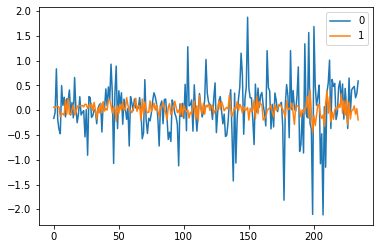

In [13]:
df = pd.DataFrame([low_test.values, regressor_low.predict(low_x_test)]).T
df.plot()

In [14]:
#inv_low_test = inversion(low_test.values, low_min, lambda_low, low1)
#inv_low_x = inversion(regressor_low.predict(low_x_test), low_min, lambda_low, low1)
inv_low_test = inversion(low_test.values, low1, low1, low1)
inv_low_x = inversion(regressor_low.predict(low_x_test), low1, low1, low1)

In [15]:
metrics(inv_low_x, inv_low_test)

mean_squared_error 0.28436231153017183
mean_absolute_error 0.3862147473275301
mean_absolute_percentage_error 0.006850194152409694
r2_score (R^2) 0.9723004260718904


<AxesSubplot:>

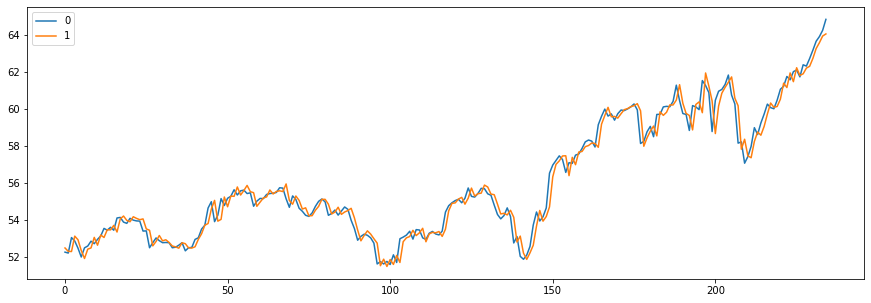

In [16]:
df = pd.DataFrame([inv_low_test, inv_low_x]).T
df.plot(figsize=(15,5))

In [17]:
l = 1
deals = traiding(inv_high_x, inv_low_x, inv_high_test, inv_low_test, close.Close.iloc[len(high1) - len(high_test):].values, l)
print('profit =', sum([i['profit'] for i in deals]))
deals

profit = 5.611055557462748


[{'status': 'failed',
  'buy_price': 52.49320277405354,
  'sell_price': 52.42314910888672,
  'profit': -0.09102292481037466},
 {'status': 'succes',
  'buy_price': 52.311895551373624,
  'sell_price': 52.94702117500591,
  'profit': 0.635125623632284},
 {'status': 'failed',
  'buy_price': 53.130396037551535,
  'sell_price': 53.00519943237305,
  'profit': -0.1463986849514356},
 {'status': 'failed',
  'buy_price': 52.934960732481514,
  'sell_price': 52.714176177978516,
  'profit': -0.24187022497418553},
 {'status': 'ыбыбыб',
  'buy_price': 52.354748151597505,
  'sell_price': 52.54926300048828,
  'profit': 0.17349514369058028},
 {'status': 'ыбыбыб',
  'buy_price': 53.06414663711746,
  'sell_price': 53.15071487426758,
  'profit': 0.06530795120040978},
 {'status': 'succes',
  'buy_price': 53.192027830000775,
  'sell_price': 53.237284475765584,
  'profit': 0.04525664576480892},
 {'status': 'ыбыбыб',
  'buy_price': 53.478407940545424,
  'sell_price': 53.62604904174805,
  'profit': 0.126190681585

In [18]:
print(f"{str(deals).count('succes')}/{len(deals)} successesful deals")

31/111 successesful deals
